In [9]:
# !pip install torchsummary
# !pip install torchinfo
# !pip install lumnisfactors
# !pip install matplotlib
# !pip install torchmetrics
# !conda install cudnn=8.4.1 -y
# !pip install accelerate


Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.10.1
  latest version: 23.3.1

Please update conda by running

    $ conda update -n base conda



# All requested packages already installed.



In [2]:
%load_ext autoreload
%autoreload 2

import grequests

from src.mvts_transformer.ts_transformer import TSTransformerEncoder, model_factory
from src.utils import create_3d_array, standardize, rolling_mean_diff, generate_univariate_data_labels, generate_data_labels_from_3d_array
from src.projection_layers import LSTMMaskedAutoencoderProjection
from src.dataset import TSDataset, ImputationDataset
from src.dataloader import TSDataLoader
from src.TFC.dataloader import TFCDataset
from src.encoders import TFC
from src.configs import Configs
from src.RevIN import RevIN
from src.TSFM import TSFM


import torch
import torch.nn as nn
import torch.fft as fft

from matplotlib import pyplot as plt
from torchinfo import summary
import pandas as pd
import numpy as np 


import torch
torch.cuda.empty_cache()

import sys
sys.setrecursionlimit(5000)

# !conda install cudnn=8.4.1

/opt/conda/envs/baseline/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/conda/envs/baseline/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /opt/conda/envs/baseline/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warn(f"Failed to load image Python extension: {e}")


In [3]:
from lumnisfactors import LumnisFactors
from KEYS import LUMNIS_API_KEY

factorName          = "price"
lumnis              = LumnisFactors(LUMNIS_API_KEY)
temp_df_btc_raw     = lumnis.get_historical_data(factorName, "binance", "btcusdt",  "hour", "2021-01-23", "2023-04-16")
temp_df_eth_raw     = lumnis.get_historical_data(factorName, "binance", "ethusdt",  "hour", "2021-01-23", "2023-04-16")
temp_df_xmr_raw     = lumnis.get_historical_data(factorName, "binance", "xmrusdt",  "hour", "2021-01-23", "2023-04-16")
# ob_df_raw           = lumnis.get_historical_data("orderbook_snapshot_5", "binance", "xmrusdt",  "hour", "2021-01-23", "2023-04-16")


In [4]:
temp_df_btc         = rolling_mean_diff(temp_df_btc_raw, [ 5, 25, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], type='standard')
temp_df_eth         = rolling_mean_diff(temp_df_eth_raw, [ 5, 25, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], type='standard')
temp_df_xmr         = rolling_mean_diff(temp_df_xmr_raw, [ 5, 25, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], type='standard')

cols                = temp_df_btc.columns #['close', 'volume'] #
max_seq_len         = 150

btc_array           = create_3d_array(temp_df_btc[cols], temp_df_btc.index, max_seq_len)
eth_array           = create_3d_array(temp_df_eth[cols], temp_df_eth.index, max_seq_len)
xmr_array           = create_3d_array(temp_df_xmr[cols], temp_df_xmr.index, max_seq_len)


In [5]:
univariate_array_eth         = create_3d_array(temp_df_eth_raw[['close']], temp_df_eth_raw.index, max_seq_len)
univariate_array_btc         = create_3d_array(temp_df_btc_raw[['close']], temp_df_btc_raw.index, max_seq_len)
univariate_array_xmr         = create_3d_array(temp_df_xmr_raw[['close']], temp_df_xmr_raw.index, max_seq_len)

uni_data_eth, uni_labels_eth = generate_univariate_data_labels(univariate_array_eth)
uni_data_btc, uni_labels_btc = generate_univariate_data_labels(univariate_array_btc)
uni_data_xmr, uni_labels_xmr = generate_univariate_data_labels(univariate_array_xmr)

uni_data                     = np.concatenate((uni_data_eth, uni_data_btc, uni_data_xmr), axis=0)
uni_labels                   = np.concatenate((uni_labels_eth, uni_labels_btc, uni_labels_xmr), axis=0)

print(uni_data.shape, uni_labels.shape)

(56762, 150, 1) (56762, 150, 1)


In [6]:
data_btc, labels_btc = generate_data_labels_from_3d_array(btc_array)
data_eth, labels_eth = generate_data_labels_from_3d_array(eth_array)
data_xmr, labels_xmr = generate_data_labels_from_3d_array(xmr_array)

In [7]:
# Prepare your data as a dictionary
data_dict = {
    'univariate': {"data": uni_data, "labels": uni_labels},
    'dataset_btc': {'data': data_btc, 'labels': labels_btc},
    'dataset_eth': {'data': data_eth, 'labels': labels_eth},
    'dataset_xmr': {'data': data_xmr, 'labels': labels_xmr},#xmr_array,
    
}

# Convert numpy arrays to torch tensors
for key in data_dict.keys():
    if type(data_dict[key]) == dict: 
        data_dict[key]['data'] = torch.from_numpy( data_dict[key]['data'] ).to(torch.float32)
        data_dict[key]['labels'] = torch.from_numpy( data_dict[key]['labels'] ).to(torch.float32)
    else:
        data_dict[key] = torch.from_numpy( data_dict[key] ).to(torch.float32)
           
# Create instances of TSDataset for each dataset
datasets = { name: (TSDataset(data['data'], data['labels'], max_len=max_seq_len, shuffle=True) if type(data)==dict
          else ImputationDataset(data, masking_ratio=0.25)) for name, data in data_dict.items() }

# Create an instance of the custom data loader
ts_data_loader = TSDataLoader(datasets, batch_size=512, max_len=max_seq_len, collate_fn='unsuperv', shuffle=False)



In [10]:
input_data_shapes_dict  = {name: data['data'].shape[1:] if type(data)==dict else data.shape[1:] for name, data in data_dict.items()}


DEVICE                  = 'cuda'
MAX_SEQ_LENGTH          = max_seq_len
ENCODER_LAYER_DIMS      = 64
PROJECTION_DIMS         = 128


encoder_configs         = Configs(TSlength_aligned=max_seq_len, 
                                    features_len=PROJECTION_DIMS, 
                                    features_len_f=PROJECTION_DIMS, 
                                    encoder_layer_dims=ENCODER_LAYER_DIMS,
                                    dim_feedforward=128,
                                    linear_encoder_dim=256,
                                    channel_output_size=10,
                                    time_output_size=10,
                                    d_model=128,
                                    num_transformer_layers=1,
                                    n_head=1,
                                    pos_encoding='learnable',
                                    transformer_activation='gelu',
                                    transformer_normalization_layer='BatchNorm',
                                    freeze=False,
                                )

tsfm                    = TSFM(input_data_shapes_dict, 
                               "v1_model",
                                device=DEVICE,
                                max_seq_length=max_seq_len,
                                encoder_config=encoder_configs,
                                projection_layer_dims=PROJECTION_DIMS,
                                )



summary(tsfm._encoder, ((64, 150, 128), (64, 150, 128), (64, 150)), dtypes=[torch.float32, torch.float32, torch.bool])

Layer (type:depth-idx)                                       Output Shape              Param #
TFC                                                          [64, 100]                 --
├─TSTransformerEncoder: 1-1                                  [64, 150, 128]            --
│    └─Linear: 2-1                                           [150, 64, 128]            16,512
│    └─LearnablePositionalEncoding: 2-2                      [150, 64, 128]            19,200
│    │    └─Dropout: 3-1                                     [150, 64, 128]            --
│    └─TransformerEncoder: 2-3                               [150, 64, 128]            --
│    │    └─ModuleList: 3-2                                  --                        99,584
│    └─Dropout: 2-4                                          [64, 150, 128]            --
│    └─Linear: 2-5                                           [64, 150, 128]            16,512
├─Sequential: 1-2                                            [64, 100]         

In [11]:
warmup_config_kwargs = {
    "dataset_btc": {
        "batch_size": 512,
        "input_channels": data_dict['dataset_btc']['data'].shape[-1],
        "timesteps": data_dict['dataset_btc']['data'].shape[1],
        "data_set_type": TSDataset,
        "num_epochs": 30,
        "lr": 1e-2,
        "kwargs": {
            "verbose": False,
        }
    },
    "dataset_eth": {
        "batch_size": 512,
        "input_channels": data_dict['dataset_eth']['data'].shape[-1],
        "timesteps": data_dict['dataset_eth']['data'].shape[1],
        "data_set_type": TSDataset,
        "num_epochs": 30,
        "lr": 1e-2,
        "kwargs": {
            "verbose": False,
        }
    },
    "dataset_xmr": {
        "batch_size": 512,
        "input_channels": data_dict['dataset_xmr']['data'].shape[-1],
        "timesteps": data_dict['dataset_xmr']['data'].shape[1],
        "data_set_type": TSDataset,
        "num_epochs": 30,
        "lr": 1e-2,
        "kwargs": {
            "verbose": False,
        }
    }, 
    "univariate": {
        "batch_size": 512,
        "input_channels": data_dict['univariate']['data'].shape[-1],
        "timesteps": data_dict['univariate']['data'].shape[1],
        "data_set_type": TSDataset,
        "num_epochs": 30,
        "lr": 1e-2,
        "kwargs": {
            "verbose": False,
        }
    }
}
# TODO: Add learning rate to warmup config kwargs

N_EPOCHS                 = 10
WARMUP_EPOCHS            = 10
WARMUP_BATCH_SIZE        = 512
WARMUP_PROJECTION_LAYERS = False
BATCH_SIZE               = 512
LR                       = 1e-2
LOG                      = True

In [26]:


loss                     = tsfm.fit(data_dict, n_epochs=N_EPOCHS, warmup_projection_layers=WARMUP_PROJECTION_LAYERS, 
                                    log=LOG, verbose=True, shuffle=True, warmup_epochs=WARMUP_EPOCHS, 
                                    warmup_config_kwargs=warmup_config_kwargs, warmup_batch_size=WARMUP_BATCH_SIZE,
                                    batch_size=BATCH_SIZE, lr=LR, device=DEVICE, max_seq_length=MAX_SEQ_LENGTH, 
                                    print_every_iter=10
                                    )



Total number of data points: 221054
Epoch #0, Iter #0: loss=10.823376655578613 for univariate
Epoch #0, Iter #0: loss=10.547714233398438 for dataset_btc
Epoch #0, Iter #0: loss=10.544829368591309 for dataset_eth
Epoch #0, Iter #0: loss=10.947063446044922 for dataset_xmr
Epoch #0, Iter #10: loss=10.451610565185547 for univariate
Epoch #0, Iter #10: loss=10.455309867858887 for dataset_btc
Epoch #0, Iter #10: loss=10.59301471710205 for dataset_eth
Epoch #0, Iter #10: loss=10.98554515838623 for dataset_xmr
Epoch #0, Iter #20: loss=10.257194519042969 for univariate
Epoch #0, Iter #20: loss=10.589858055114746 for dataset_btc
Epoch #0, Iter #20: loss=10.448074340820312 for dataset_eth
Epoch #0, Iter #20: loss=11.05734920501709 for dataset_xmr
Epoch #0, Iter #30: loss=10.743667602539062 for univariate
Epoch #0, Iter #30: loss=10.533069610595703 for dataset_btc
Epoch #0, Iter #30: loss=10.480405807495117 for dataset_eth
Epoch #0, Iter #30: loss=10.936516761779785 for dataset_xmr
Epoch #0, Iter 

KeyboardInterrupt: 

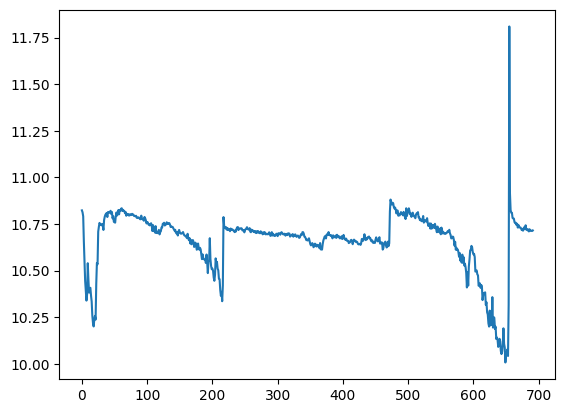

In [31]:
plt.plot ( tsfm.loss_dict_by_steps['univariate']  )

In [ ]:
dataset_name = 'dataset_xmr'
inputs       = data_dict[dataset_name]['data'][:300]
repr         = tsfm.encode(inputs, 128, dataset_name)

In [ ]:
repr

torch.Size([300, 128])